# [Explaining Text Classification](https://coderzcolumn.com/tutorials/artificial-intelligence/explain-text-classification-models-using-shap-values-keras)

In [1]:
from explainer.explainers import feature_attributions_explainer, metrics_explainer
feature_attributions_explainer.entry_points

True

In [2]:
import numpy as np
from sklearn import datasets

all_categories = ['alt.atheism','comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware',
                  'comp.sys.mac.hardware','comp.windows.x', 'misc.forsale','rec.autos','rec.motorcycles',
                  'rec.sport.baseball','rec.sport.hockey','sci.crypt','sci.electronics','sci.med',
                  'sci.space','soc.religion.christian','talk.politics.guns','talk.politics.mideast',
                  'talk.politics.misc','talk.religion.misc']

selected_categories = ['alt.atheism','comp.graphics','rec.motorcycles','sci.space','talk.politics.misc']

X_train_text, Y_train = datasets.fetch_20newsgroups(subset="train", categories=selected_categories, return_X_y=True)
X_test_text , Y_test  = datasets.fetch_20newsgroups(subset="test", categories=selected_categories, return_X_y=True)

X_train_text = np.array(X_train_text)
X_test_text = np.array(X_test_text)

classes = np.unique(Y_train)
mapping = dict(zip(classes, selected_categories))

len(X_train_text), len(X_test_text), classes, mapping

(2720,
 1810,
 array([0, 1, 2, 3, 4]),
 {0: 'alt.atheism',
  1: 'comp.graphics',
  2: 'rec.motorcycles',
  3: 'sci.space',
  4: 'talk.politics.misc'})

In [3]:
print(Y_test)

[2 3 0 ... 3 2 3]


## Vectorize Text Data

In [4]:
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=50000)

vectorizer.fit(np.concatenate((X_train_text, X_test_text)))
X_train = vectorizer.transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

X_train, X_test = X_train.toarray(), X_test.toarray()

X_train.shape, X_test.shape

((2720, 50000), (1810, 50000))

## Define the Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def create_model():
    return Sequential([
                        layers.Input(shape=X_train.shape[1:]),
                        layers.Dense(128, activation="relu"),
                        layers.Dense(64, activation="relu"),
                        layers.Dense(len(classes), activation="softmax"),
                    ])

model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6400128   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 6,408,709
Trainable params: 6,408,709
Non-trainable params: 0
_________________________________________________________________


2022-10-18 18:25:18.257793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=1
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=768
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=1
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defin

## Compile and Train Model

In [6]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, Y_train, batch_size=256, epochs=5, validation_data=(X_test, Y_test))

Epoch 1/5
11/11 [==============================] - 4s 263ms/step - loss: 1.5400 - accuracy: 0.7132 - val_loss: 1.4321 - val_accuracy: 0.8376
Epoch 2/5
11/11 [==============================] - 2s 169ms/step - loss: 1.1843 - accuracy: 0.9790 - val_loss: 1.1037 - val_accuracy: 0.8939
Epoch 3/5
11/11 [==============================] - 2s 146ms/step - loss: 0.6873 - accuracy: 0.9956 - val_loss: 0.7225 - val_accuracy: 0.9260
Epoch 4/5
11/11 [==============================] - 1s 140ms/step - loss: 0.2845 - accuracy: 0.9985 - val_loss: 0.4516 - val_accuracy: 0.9431
Epoch 5/5
11/11 [==============================] - 1s 102ms/step - loss: 0.1003 - accuracy: 0.9996 - val_loss: 0.3210 - val_accuracy: 0.9497


## Evaluate Model Performance

In [7]:
from sklearn.metrics import accuracy_score, classification_report

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print("Train Accuracy : {:.3f}".format(accuracy_score(Y_train, np.argmax(train_preds, axis=1))))
print("Test  Accuracy : {:.3f}".format(accuracy_score(Y_test, np.argmax(test_preds, axis=1))))
print("\nClassification Report : ")
print(classification_report(Y_test, np.argmax(test_preds, axis=1), target_names=selected_categories))

57/57 [==============================] - 1s 10ms/step
Train Accuracy : 1.000
Test  Accuracy : 0.950

Classification Report : 
                    precision    recall  f1-score   support

       alt.atheism       0.97      0.93      0.95       319
     comp.graphics       0.94      0.97      0.95       389
   rec.motorcycles       0.97      0.99      0.98       398
         sci.space       0.92      0.94      0.93       394
talk.politics.misc       0.96      0.90      0.93       310

          accuracy                           0.95      1810
         macro avg       0.95      0.95      0.95      1810
      weighted avg       0.95      0.95      0.95      1810



                    precision    recall  f1-score   support

       alt.atheism       0.97      0.93      0.95       319
     comp.graphics       0.94      0.97      0.95       389
   rec.motorcycles       0.97      0.99      0.98       398
         sci.space       0.92      0.94      0.93       394
talk.politics.misc       0.96      0.90      0.93       310

          accuracy                           0.95      1810
         macro avg       0.95      0.95      0.95      1810
      weighted avg       0.95      0.95      0.95      1810



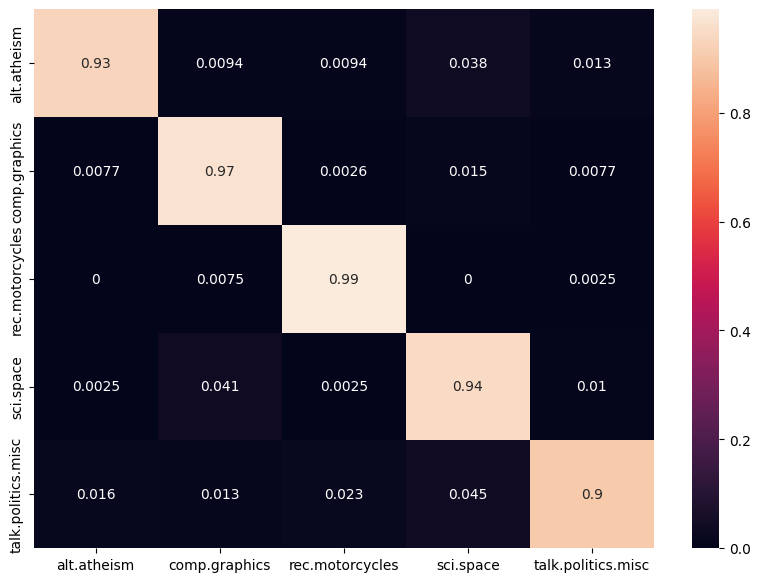

In [8]:
# one-hot-encode clasess
oh_Y_test = np.eye(len(classes))[Y_test]

cm = metrics_explainer['confusionmatrix'](oh_Y_test, test_preds, selected_categories)
cm.visualize()
print(cm.report)

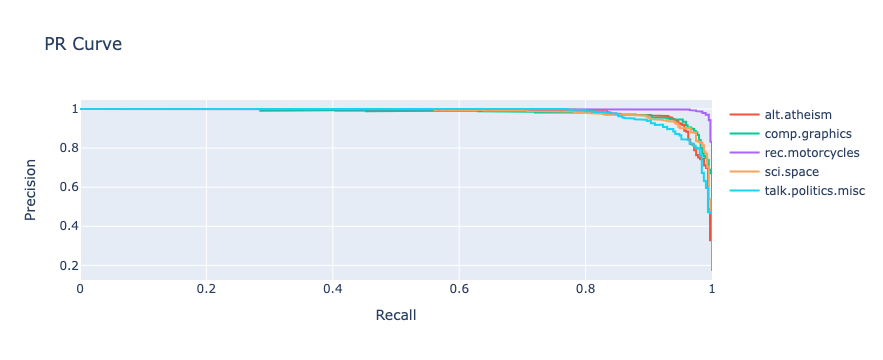

In [10]:
plotter = metrics_explainer['plot'](oh_Y_test, test_preds, selected_categories)
plotter.pr_curve()

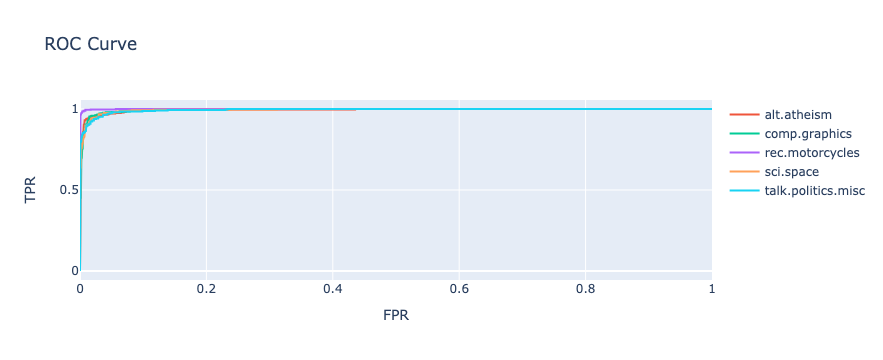

In [11]:
plotter.roc_curve()

## SHAP Partition Explainer

In [12]:
import shap
def make_predictions(X_batch_text):
    X_batch = vectorizer.transform(X_batch_text).toarray()
    preds = model.predict(X_batch)
    return preds

masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions, masker=masker, output_names=selected_categories)

explainer

## Visualize SHAP Values Correct Predictions

In [13]:
import re

X_batch_text = X_test_text[1:3]
X_batch = X_test[1:3]

print("Samples : ")
for text in X_batch_text:
    print(re.split(r"\W+", text))
    print()

preds_proba = model.predict(X_batch)
preds = preds_proba.argmax(axis=1)

# print("Actual    Target Values : {}".format([selected_categories[target] for target in Y_test[1:3]]))
# print("Predicted Target Values : {}".format([selected_categories[target] for target in preds]))
# print("Predicted Probabilities : {}".format(preds_proba.max(axis=1)))

shap_values = explainer(X_batch_text)

Samples : 
['From', 'prb', 'access', 'digex', 'net', 'Pat', 'Subject', 'Re', 'Near', 'Miss', 'Asteroids', 'Q', 'Organization', 'Express', 'Access', 'Online', 'Communications', 'Greenbelt', 'MD', 'USA', 'Lines', '4', 'Distribution', 'sci', 'NNTP', 'Posting', 'Host', 'access', 'digex', 'net', 'TRry', 'the', 'SKywatch', 'project', 'in', 'Arizona', 'pat', '']

['From', 'cobb', 'alexia', 'lis', 'uiuc', 'edu', 'Mike', 'Cobb', 'Subject', 'Science', 'and', 'theories', 'Organization', 'University', 'of', 'Illinois', 'at', 'Urbana', 'Lines', '19', 'As', 'per', 'various', 'threads', 'on', 'science', 'and', 'creationism', 'I', 've', 'started', 'dabbling', 'into', 'a', 'book', 'called', 'Christianity', 'and', 'the', 'Nature', 'of', 'Science', 'by', 'JP', 'Moreland', 'A', 'question', 'that', 'I', 'had', 'come', 'from', 'one', 'of', 'his', 'comments', 'He', 'stated', 'that', 'God', 'is', 'not', 'necessarily', 'a', 'religious', 'term', 'but', 'could', 'be', 'used', 'as', 'other', 'scientific', 'terms'

The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
dpctl could not find any non-host SYCL device on the system. A non-host SYCL device is required to use numba_dpex.
Numba extension module 'numba_dpex.numpy_usm_shared' failed to load due to 'ImportError(No non-host SYCL device found to execute kernels.)'.


1/1 [==============================] - 0s 102ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 67ms/step


Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 66ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 64ms/step


Partition explainer: 3it [00:42, 21.42s/it]               


### Text Plot

In [14]:
shap.text_plot(shap_values)

### Bar Plots

#### Bar Plot 1

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


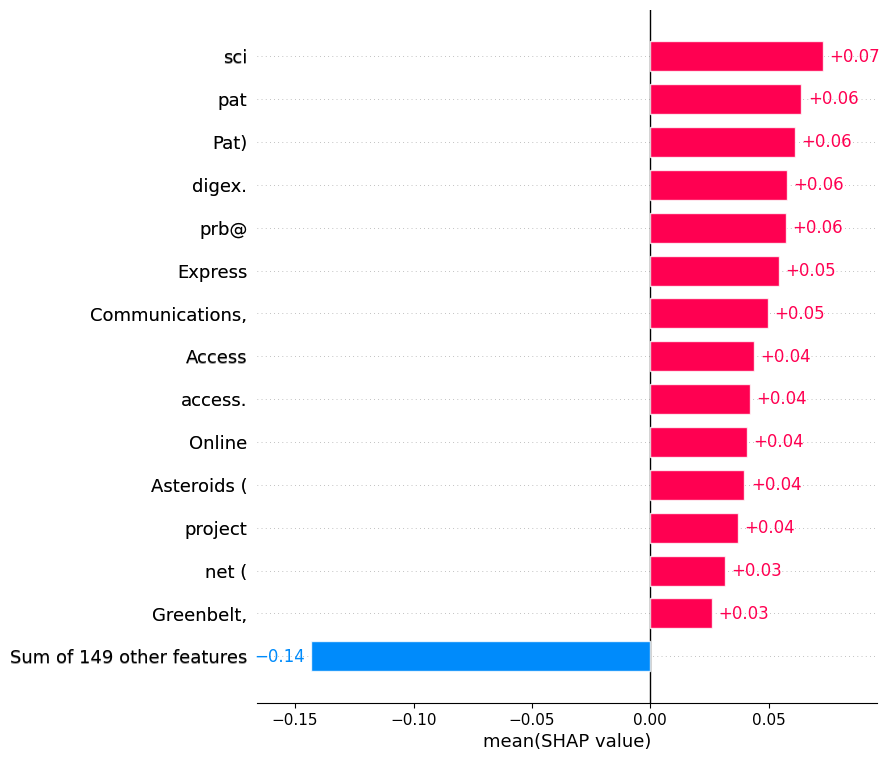

In [15]:
shap.plots.bar(shap_values[:,:, selected_categories[preds[0]]].mean(axis=0), max_display=15,
               order=shap.Explanation.argsort.flip)

#### Bar Plot 2

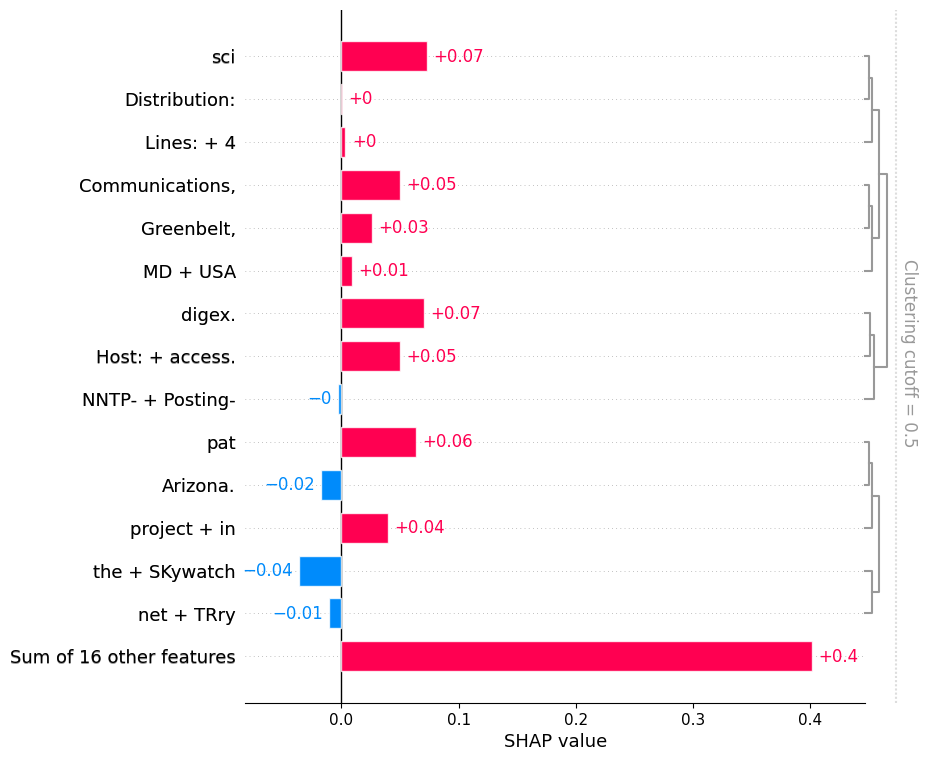

In [16]:
shap.plots.bar(shap_values[0,:, selected_categories[preds[0]]], max_display=15,
               order=shap.Explanation.argsort.flip)

### Bar Plot 3

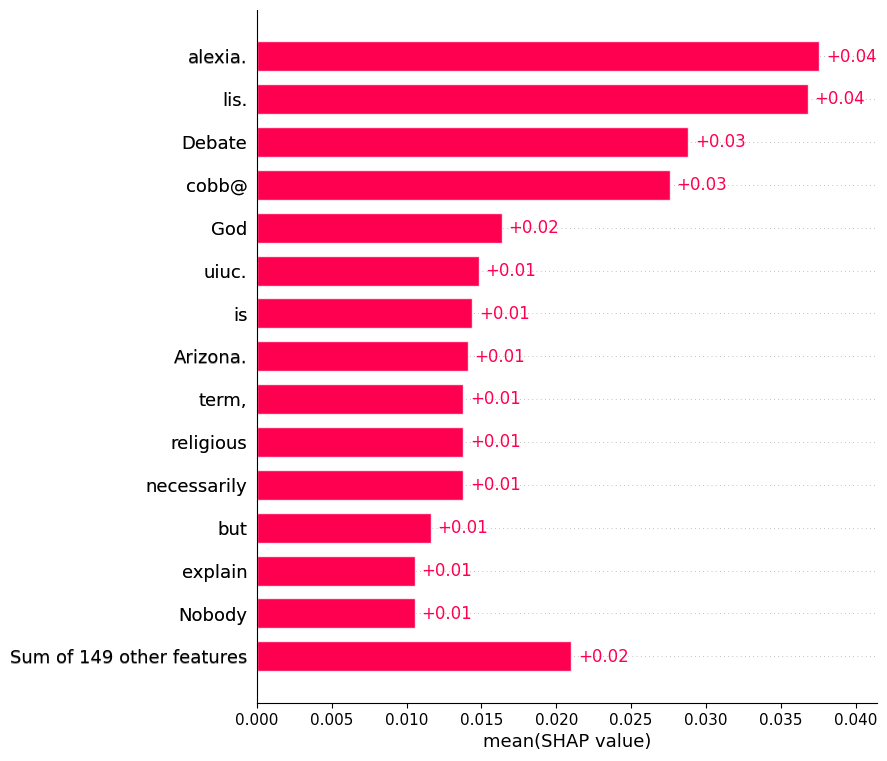

In [17]:
shap.plots.bar(shap_values[:,:, selected_categories[preds[1]]].mean(axis=0), max_display=15,
               order=shap.Explanation.argsort.flip)

### Bar Plot 4

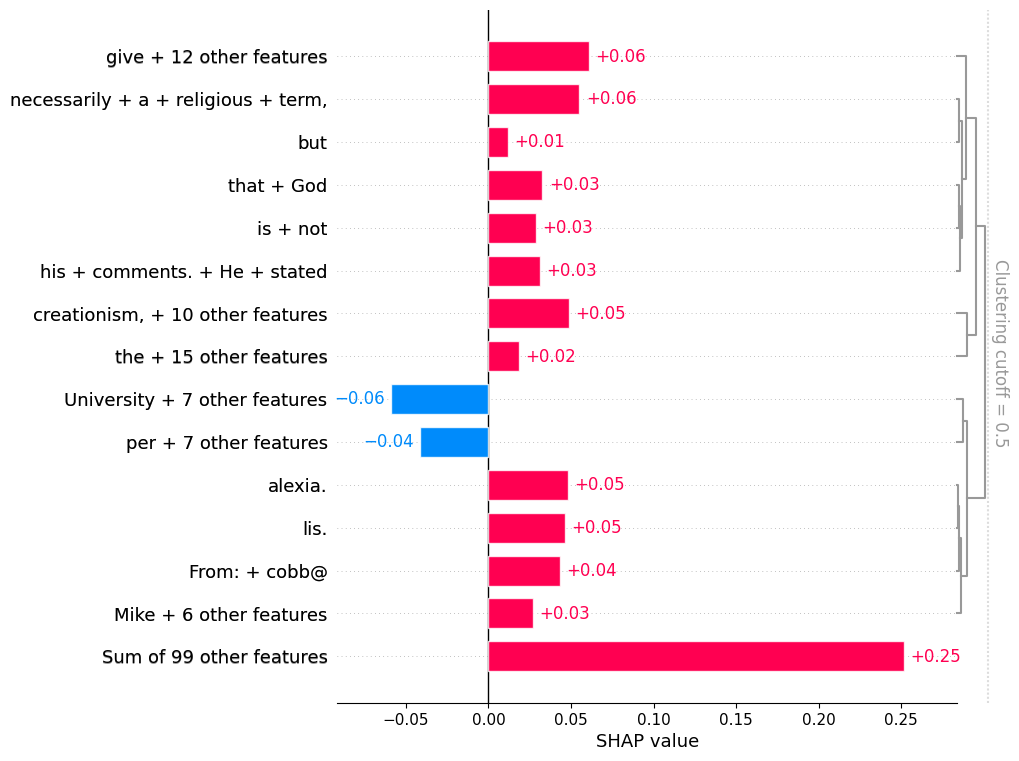

In [18]:
shap.plots.bar(shap_values[1,:, selected_categories[preds[1]]], max_display=15,
               order=shap.Explanation.argsort.flip)

## Waterfall Plots

### Waterfall Plot 1

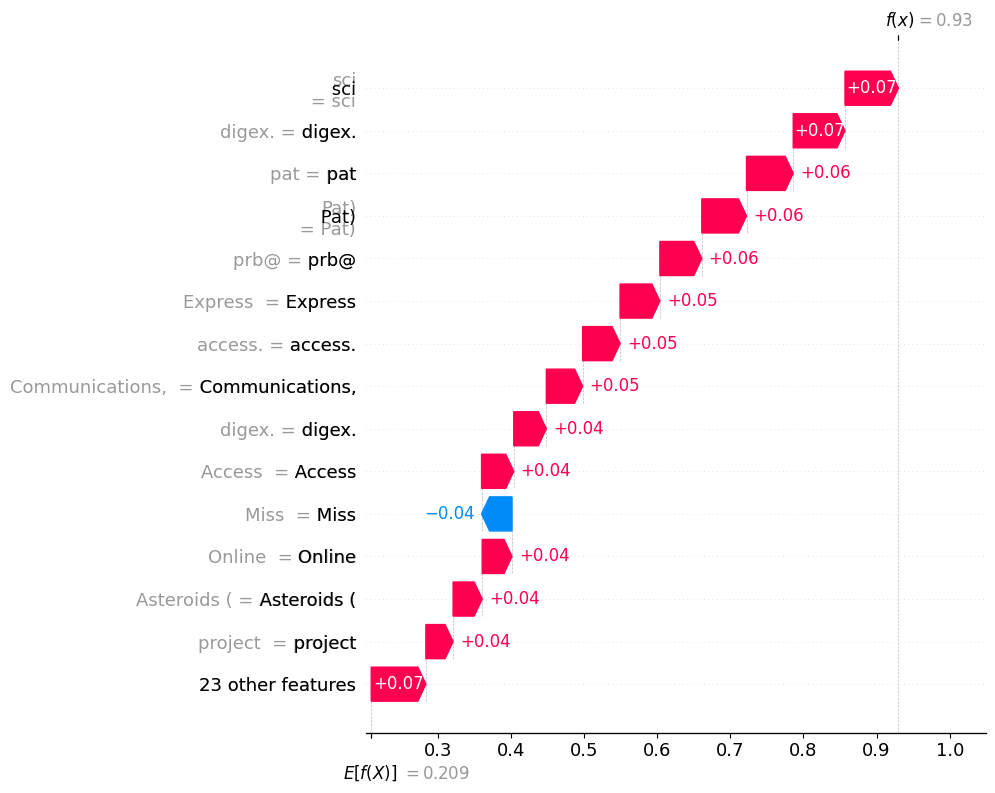

In [19]:
shap.waterfall_plot(shap_values[0][:, selected_categories[preds[0]]], max_display=15)

### Waterfall Plot 2

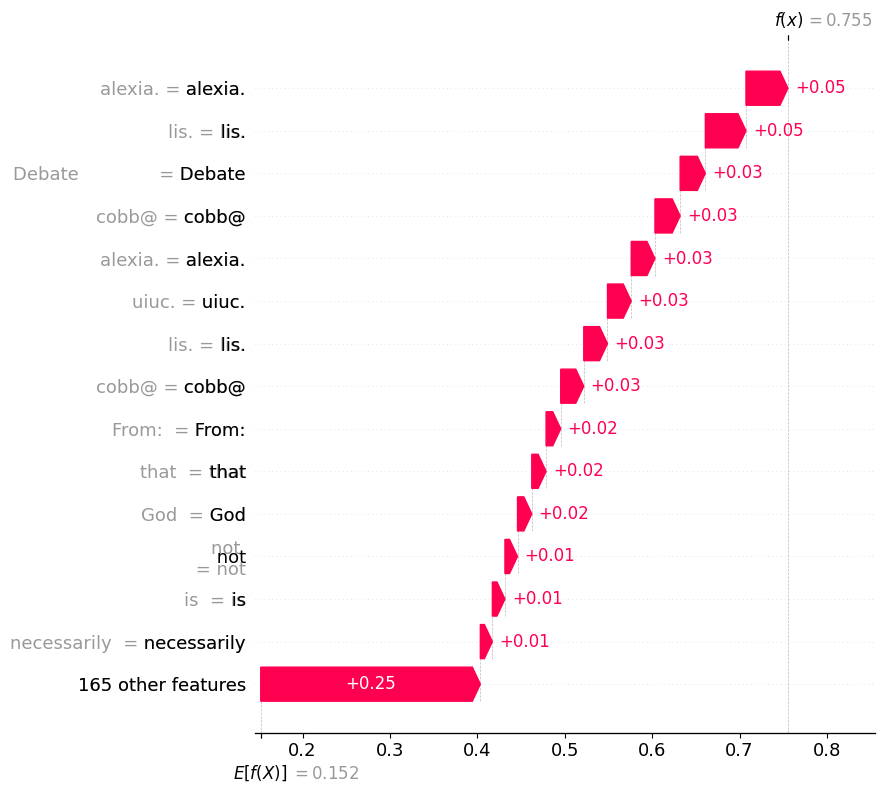

In [20]:
shap.waterfall_plot(shap_values[1][:, selected_categories[preds[1]]], max_display=15)

## Force Plot

In [21]:
import re
tokens = re.split("\W+", X_batch_text[0].lower())
shap.initjs()
shap.force_plot(shap_values.base_values[0][preds[0]], shap_values[0][:, preds[0]].values,
                feature_names = tokens[:-1], out_names=selected_categories[preds[0]])